# Pokemon: Generation I Capture Mechanism Modelling

In [ ]:
# Import libraries
import random
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette=None)
import plotly.graph_objects as go

from ipywidgets import interactive
import ipywidgets as widgets
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

## Mechanism
Source:
- [https://www.dragonflycave.com/mechanics/gen-i-capturing](https://www.dragonflycave.com/mechanics/gen-i-capturing)
- [https://bulbapedia.bulbagarden.net/wiki/Catch_rate](https://bulbapedia.bulbagarden.net/wiki/Catch_rate)

The function `capture_pokemon` determines if the pokemon is caught or not, depending on four parameters:
- Ball
- Current Pokemon Status
- Capture rate of the Pokemon
- Current HP of the Pokemon

The outcome is determined by passing though two "filters":
- Filter 1 depends on Ball, Status and Capture rate.
- Filter 2 depends on Ball and HP.

In [ ]:
def capture_pokemon(ball, status, capture_rate, hp):
    """
    Simulate the capture process and determine if the Pokémon is caught.

    Args:
        ball (str): Type of ball used ("Master Ball", "Poké Ball", "Great Ball", "Ultra Ball", "Safari Ball").
        status (str): Status condition of the Pokémon ("normal", "asleep", "frozen", "paralyzed", "burned", "poisoned").
        capture_rate (int): The capture rate of the Pokémon (from 3 to 255).
        hp (float): Percentage of current HP of the Pokemon (from 0 to 1)

    Returns:
        bool: True if the Pokémon is caught and False and if the Pokémon breaks free.
    """

    # Check entries
    valid_balls = ["Master Ball", "Poké Ball", "Great Ball", "Ultra Ball", "Safari Ball"]
    valid_status = ["normal", "asleep", "frozen", "paralyzed", "burned", "poisoned"]
    if capture_rate not in range(3, 256):
        raise ValueError(f"Invalid capture_rate. Please use enter a integer between 3 and 255.")
    if hp < 0.0 or hp > 1.0:
        raise ValueError(f"Invalid hp. Please use enter a number between 0 and 1.")


    # Variable B1 for types of Ball
    if ball == "Master Ball":
        return True
    elif ball == "Poké Ball":
        B1 = random.randint(0, 256)
    elif ball == "Great Ball":
        B1 = random.randint(0, 201)
    elif ball == "Ultra Ball" or ball == "Safari Ball":
        B1 = random.randint(0, 151)
    else:
        raise ValueError(f"Invalid ball type. Please use one of the following: {valid_balls}")


    # Variable S for Pokemon status
    if status == "normal":
        S = 0
    elif status == "paralyzed" or status == "burned" or status == "poisoned":
        S = 12
    elif status == "asleep" or status == "frozen":
        S = 25
    else:
        raise ValueError(f"Invalid status. Please use one of the following: {valid_status}")



    # Filter 1: Ball, Status, Capture rate
    if B1 - S < 0:
        return True
    elif B1 - S > capture_rate:
        return False


    # Filter 2: Ball, HP
    # Variable B2 for types of Ball
    if ball == "Great Ball":
        B2 = 8
    else:
        B2 = 12

    # Variable F depending on B2 and HP
    F = max(1, min(math.floor(255 * 4 / hp / B2), 255))

    if F >= random.randint(0, 256):
        return True
    else:
        return False

In [ ]:
import random
import math

def capture_pokemon(ball, status, capture_rate, hp):
    """
    Simulate the capture process and determine if the Pokémon is caught.

    Args:
        ball (str): Type of ball used ("Master Ball", "Poké Ball", "Great Ball", "Ultra Ball", "Safari Ball").
        status (str): Status condition of the Pokémon ("normal", "asleep", "frozen", "paralyzed", "burned", "poisoned").
        capture_rate (int): The capture rate of the Pokémon (from 3 to 255).
        hp (float): Percentage of current HP of the Pokémon (from 0 to 1).

    Returns:
        bool: True if the Pokémon is caught, False if the Pokémon breaks free.

    The function first validates the input parameters to ensure they fall within acceptable ranges.
    Then, it uses various algorithms to simulate the capturing process based on the provided inputs.
    """

    # Check entries
    valid_balls = ["Master Ball", "Poké Ball", "Great Ball", "Ultra Ball", "Safari Ball"]
    valid_status = ["normal", "asleep", "frozen", "paralyzed", "burned", "poisoned"]

    # Check if capture rate and HP are within valid ranges
    if capture_rate not in range(3, 256):
        raise ValueError(f"Invalid capture_rate. Please enter an integer between 3 and 255.")
    if hp < 0.0 or hp > 1.0:
        raise ValueError(f"Invalid hp. Please enter a number between 0 and 1.")

    # Variable B1 for types of Ball
    if ball == "Master Ball":
        # Return True if a Master Ball is used (instant capture)
        return True
    elif ball == "Poké Ball":
        B1 = random.randint(0, 256)
    elif ball == "Great Ball":
        B1 = random.randint(0, 201)
    elif ball == "Ultra Ball" or ball == "Safari Ball":
        B1 = random.randint(0, 151)
    else:
        # Raise ValueError for invalid ball types
        raise ValueError(f"Invalid ball type. Please use one of the following: {valid_balls}")

    # Variable S for Pokemon status
    if status == "normal":
        S = 0
    elif status == "paralyzed" or status == "burned" or status == "poisoned":
        S = 12
    elif status == "asleep" or status == "frozen":
        S = 25
    else:
        # Raise ValueError for invalid status
        raise ValueError(f"Invalid status. Please use one of the following: {valid_status}")

    # Filter 1: Ball, Status, Capture rate
    if B1 - S < 0:
        # If the result is negative, the Pokémon is caught
        return True
    elif B1 - S > capture_rate:
        # If the result is greater than capture rate, the Pokémon breaks free
        return False

    # Filter 2: Ball, HP
    # Variable B2 for types of Ball
    if ball == "Great Ball":
        B2 = 8
    else:
        B2 = 12

    # Variable F depending on B2 and HP
    F = max(1, min(math.floor(255 * 4 / hp / B2), 255))

    if F >= random.randint(0, 256):
        # If F is greater or equal to a random value, the Pokémon is caught
        return True
    else:
        # Otherwise, the Pokémon breaks free
        return False

In [ ]:
# Application example
capture_pokemon(ball="Poké Ball", status="normal", capture_rate=125, hp=0.5)

False

---

## Chance of Capture Calculation
The function `capture_chance` determines the probabilities of:
- capture after filter 1
- capture after filter 2
- fail after filter 2
- fail after filter 1

In [ ]:
def capture_chance(ball, status, capture_rate, hp):
    """
    Calculate the chance the Pokemon is caught.

    Args:
        ball (str): Type of ball used ("Master Ball", "Poké Ball", "Great Ball", "Ultra Ball", "Safari Ball").
        status (str): Status condition of the Pokémon ("normal", "asleep", "frozen", "paralyzed", "burned", "poisoned").
        capture_rate (int): The capture rate of the Pokémon.
        hp (float): Percentage of current HP of the Pokemon (from 0 to 1)

    Returns:
        list of float: [
        chance of success after filter 1,
        chance of success after filter 2,
        chance of fail after filter 2,
        chance of fail after filter 1]
    """

    # Check entries
    valid_balls = ["Master Ball", "Poké Ball", "Great Ball", "Ultra Ball", "Safari Ball"]
    valid_status = ["normal", "asleep", "frozen", "paralyzed", "burned", "poisoned"]
    if capture_rate not in range(3, 256):
        raise ValueError(f"Invalid capture_rate. Please use enter a integer between 3 and 255.")
    if hp < 0.0 or hp > 1.0:
        raise ValueError(f"Invalid hp. Please use enter a number between 0 and 1.")


    # Variable B1 for types of Ball
    if ball == "Master Ball":
        return [1.0, 0.0, 0.0, 0.0]
    elif ball == "Poké Ball":
        B1 = 256
        B2 = 12
    elif ball == "Great Ball":
        B1 = 201
        B2 = 8
    elif ball == "Ultra Ball" or ball == "Safari Ball":
        B1 = 151
        B2 = 12
    else:
        raise ValueError(f"Invalid ball type. Please use one of the following: {valid_balls}")


    # Variable S for Pokemon status
    if status == "normal":
        S = 0
    elif status == "paralyzed" or status == "burned" or status == "poisoned":
        S = 12
    elif status == "asleep" or status == "frozen":
        S = 25
    else:
        raise ValueError(f"Invalid status. Please use one of the following: {valid_status}")

    # Variable F for filter 2 calculation
    F = max(1, min(math.floor(255 * 4 / hp / B2), 255))

    # Result
    p_success_1 = S/B1
    p_fail_1 = max(0, 1 - (capture_rate+S+1)/B1) # if negetive -> 0
    p_2 = 1 - p_success_1 - p_fail_1 # probability to go to filter 2
    p_success_2 = p_2 * ((F+1)/256)
    p_fail_2 = p_2 * (1-((F+1)/256))

    return [p_success_1, p_success_2, p_fail_2, p_fail_1]

In [ ]:
# Application example
capture_chance(ball="Ultra Ball", status="burned", capture_rate=45, hp=0.1)

[0.07947019867549669, 0.304635761589404, 0.0, 0.6158940397350994]

### Visualization

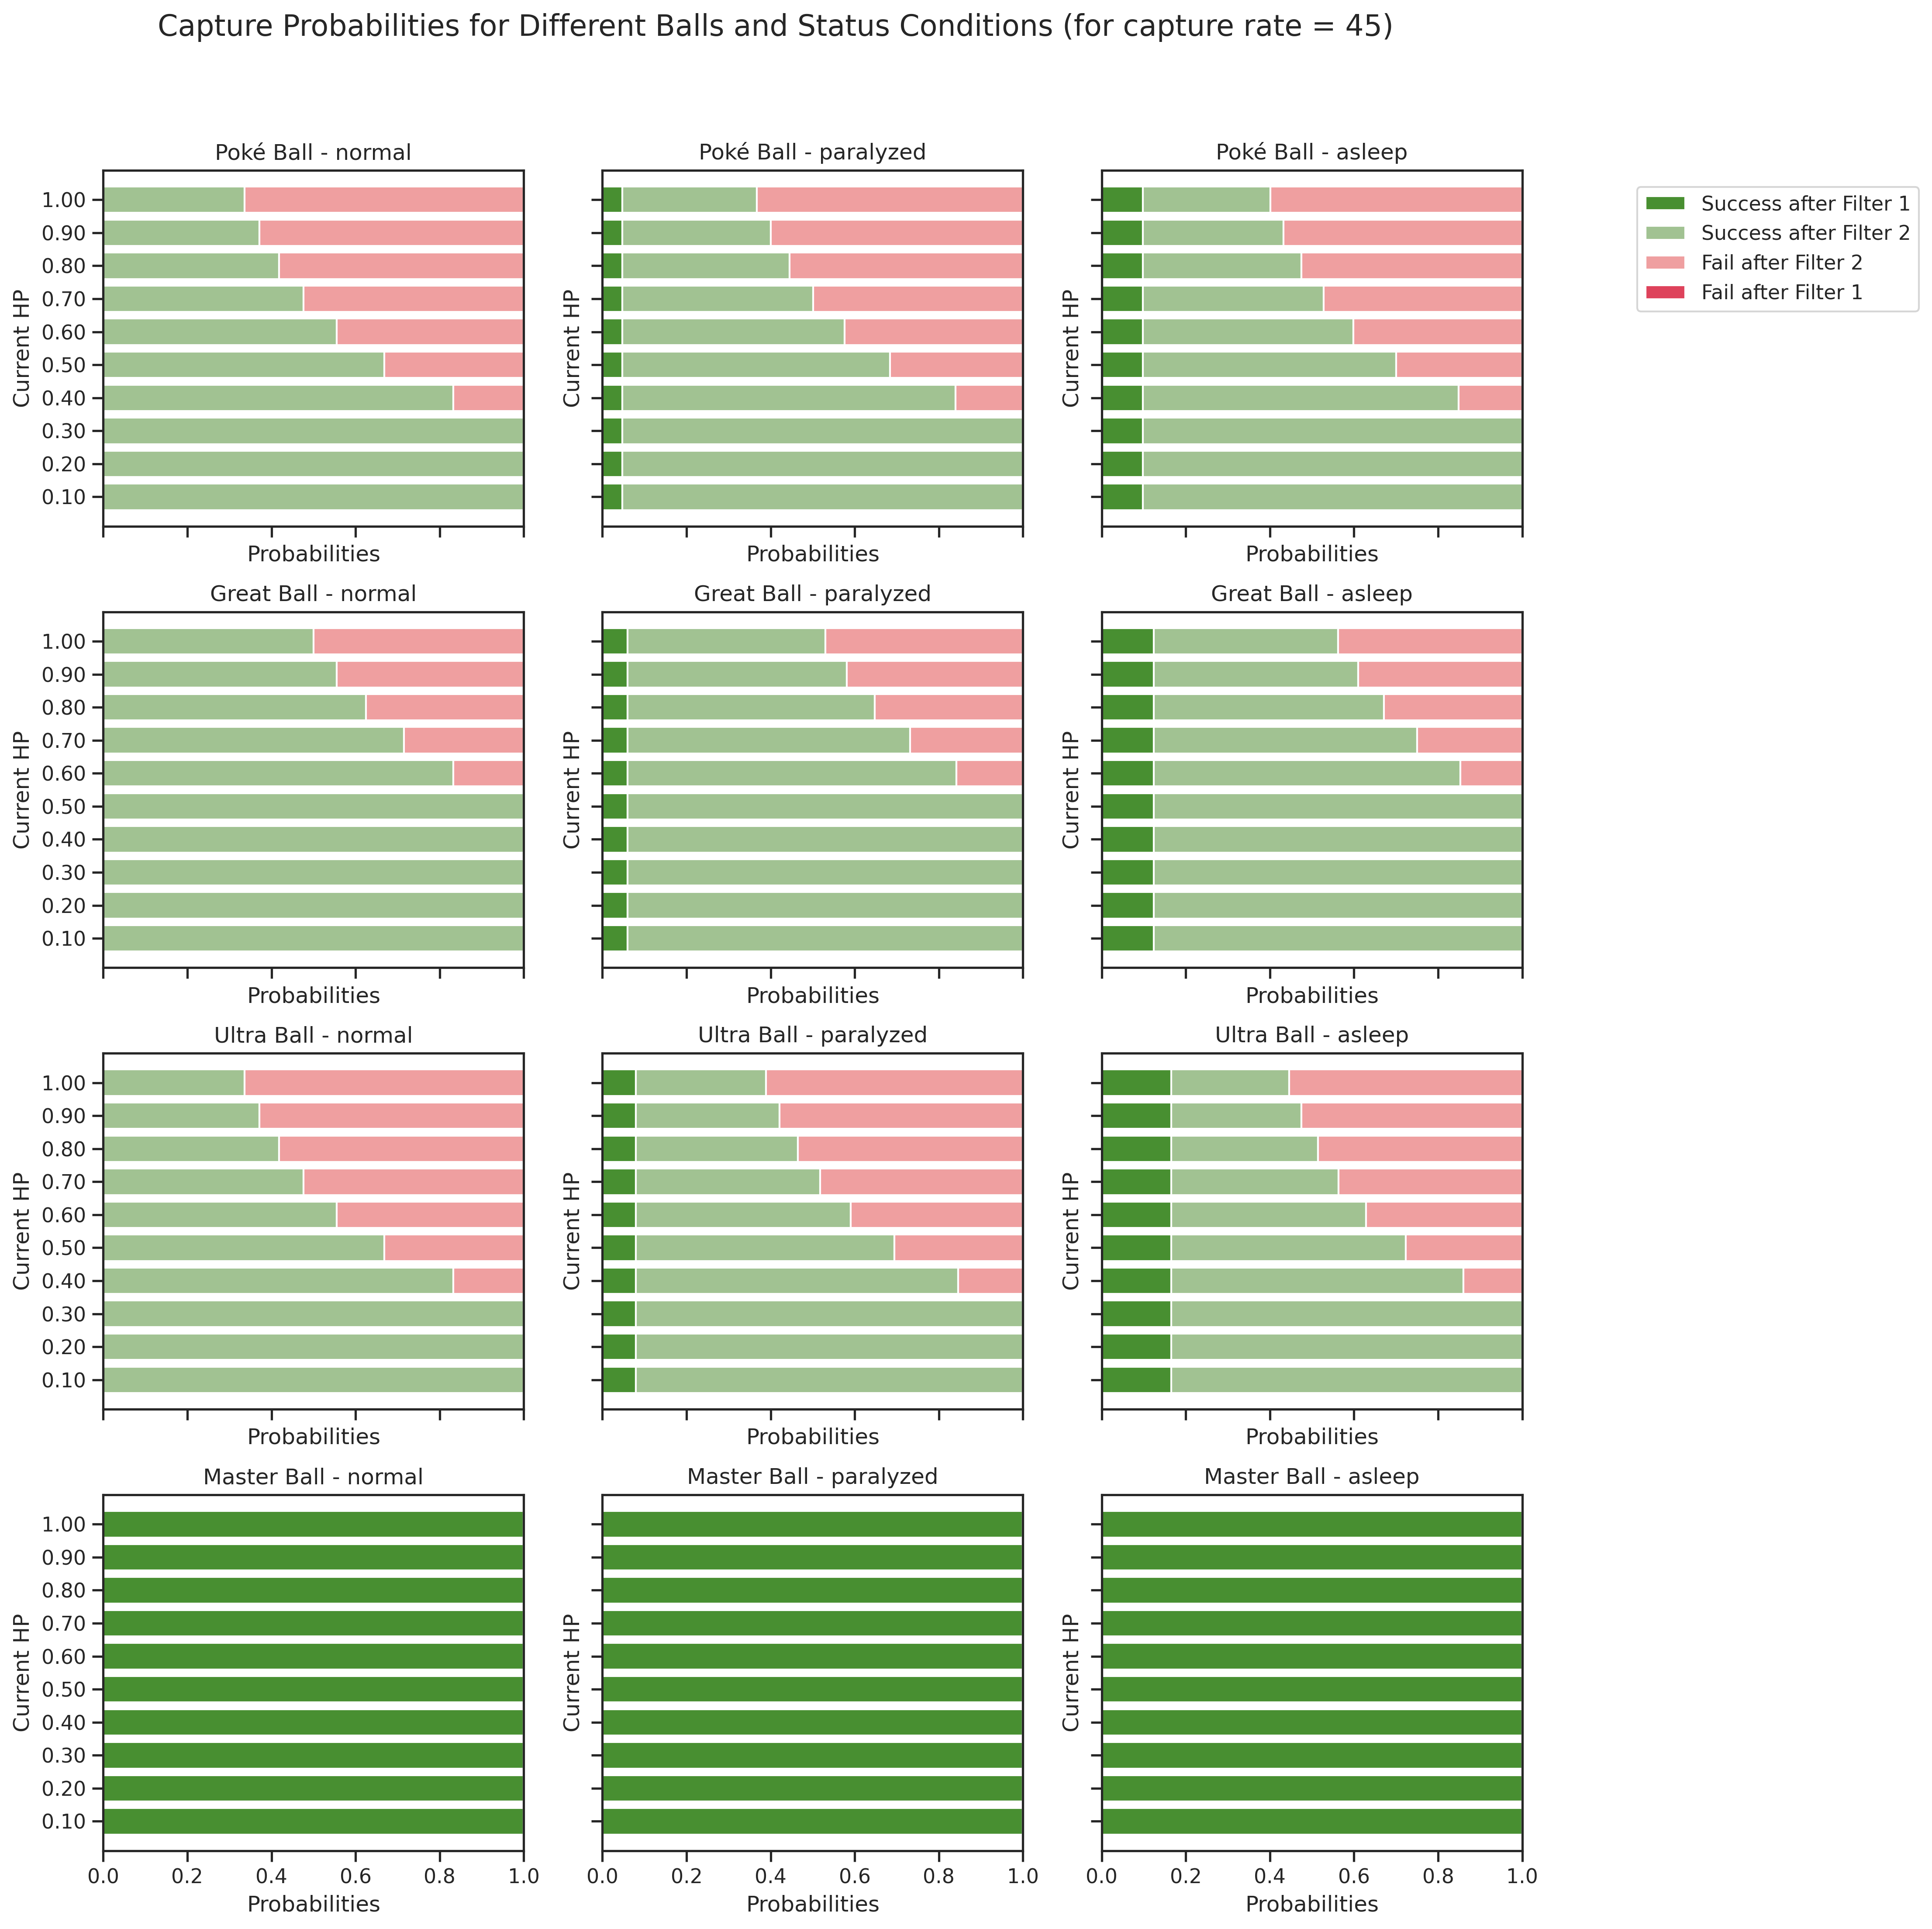

In [ ]:
def filter_chance_plot(capture_rate):
    # Define parameter values
    hp_values = np.linspace(0.1, 1.0, 10)
    balls = ["Poké Ball", "Great Ball", "Ultra Ball", "Master Ball"]
    status_conditions = ["normal", "paralyzed", "asleep"]

    # Create subplots for each combination of ball and status
    fig, axes = plt.subplots(len(balls), len(status_conditions), figsize=(12, 15), sharex=True, sharey=True)

    # Loop through each combination of ball and status and create horizontal grouped stacked bar charts
    for ball_index, ball in enumerate(balls):
        for status_index, status in enumerate(status_conditions):
            probabilities = [capture_chance(ball, status, capture_rate, hp) for hp in hp_values]

            # Extract individual probabilities
            success_filter1 = [prob[0] for prob in probabilities]
            success_filter2 = [prob[1] for prob in probabilities]
            fail_filter2 = [prob[2] for prob in probabilities]
            fail_filter1 = [prob[3] for prob in probabilities]

            # Calculate position for bars within the group
            position = np.arange(len(hp_values))

            # Define colors
            colors = ['#488F31', '#A1C292', '#EF9FA0', '#DE425B']  # Dark Green, Light Green, Light Red, Dark Red

            # Create horizontal stacked bar chart for the current ball and status in the respective subplot
            axes[ball_index, status_index].barh(position, success_filter1, label='Success after Filter 1', color=colors[0])
            axes[ball_index, status_index].barh(position, success_filter2, label='Success after Filter 2', color=colors[1], left=success_filter1)
            axes[ball_index, status_index].barh(position, fail_filter2, label='Fail after Filter 2', color=colors[2], left=np.array(success_filter1) + np.array(success_filter2))
            axes[ball_index, status_index].barh(position, fail_filter1, label='Fail after Filter 1', color=colors[3], left=np.array(success_filter1) + np.array(success_filter2) + np.array(fail_filter2))

            # Set subplot titles and labels
            axes[ball_index, status_index].set_title(f'{ball} - {status}')
            axes[ball_index, status_index].set_yticks(position)
            axes[ball_index, status_index].set_yticklabels([f'{hp:.2f}' for hp in hp_values])
            axes[ball_index, status_index].set_ylabel('Current HP')
            axes[ball_index, status_index].set_xlabel('Probabilities')

    # Set overall plot title
    plt.suptitle('Capture Probabilities for Different Balls and Status Conditions (for capture rate = 45)', fontsize=16)

    # Adjust layout to prevent overlapping titles and labels
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 4.5))
    plt.show()

# Vary capture_rate with the slider
capture_rate_slider = interactive(filter_chance_plot, capture_rate=widgets.IntSlider(min=3, max=255, step=2, value=45))
display(capture_rate_slider)

# filter_chance_plot(capture_rate=45)

In [ ]:
# Application example
capture_chance(ball="Great Ball", status="normal", capture_rate=255, hp=0.5)

[0.0, 1.0, 0.0, 0]

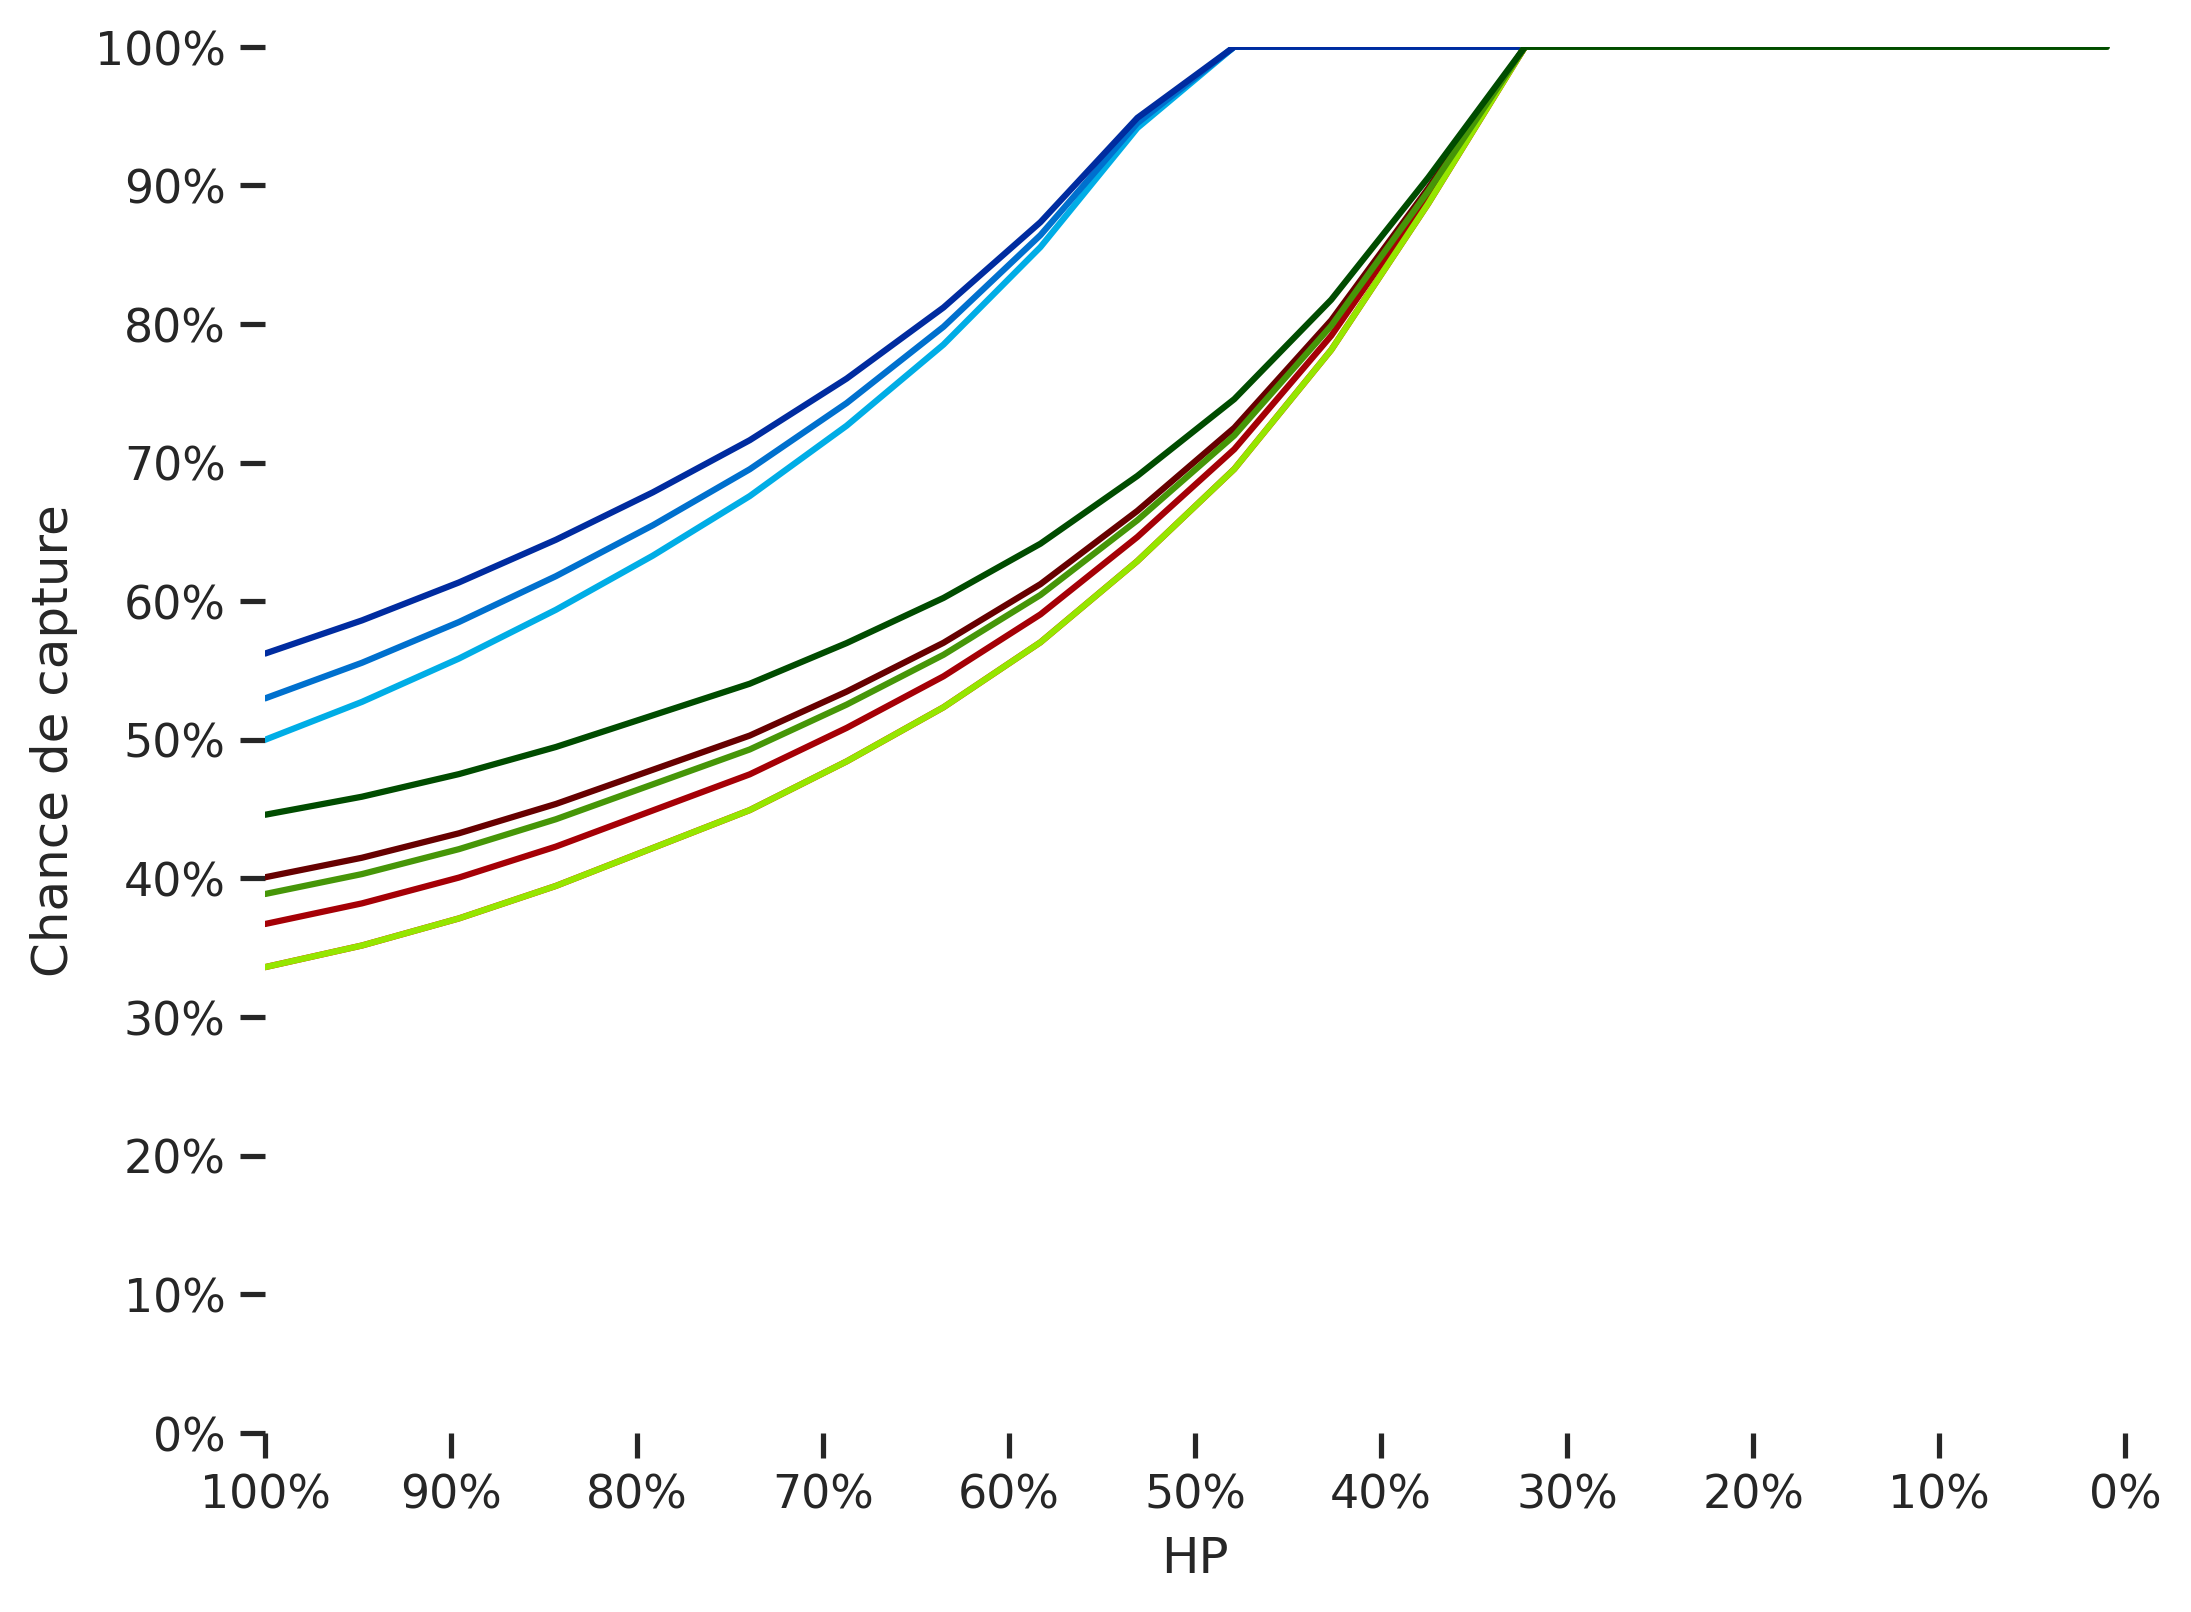

In [ ]:
def total_chance_plot(capture_rate):
    hp_list = np.linspace(0.01, 1.0, 20)
    pokeball_normal_chance = [sum(capture_chance("Poké Ball", "normal", capture_rate, hp)[:2]) for hp in hp_list]
    pokeball_paralyzed_chance = [sum(capture_chance("Poké Ball", "paralyzed", capture_rate, hp)[:2]) for hp in hp_list]
    pokeball_asleep_chance = [sum(capture_chance("Poké Ball", "asleep", capture_rate, hp)[:2]) for hp in hp_list]


    greatball_normal_chances = [sum(capture_chance("Great Ball", "normal", capture_rate, hp)[:2]) for hp in hp_list]
    greatball_paralyzed_chances = [sum(capture_chance("Great Ball", "paralyzed", capture_rate, hp)[:2]) for hp in hp_list]
    greatball_asleep_chances = [sum(capture_chance("Great Ball", "asleep", capture_rate, hp)[:2]) for hp in hp_list]


    ultraball_normal_chances = [sum(capture_chance("Ultra Ball", "normal", capture_rate, hp)[:2]) for hp in hp_list]
    ultraball_paralyzed_chances = [sum(capture_chance("Ultra Ball", "paralyzed", capture_rate, hp)[:2]) for hp in hp_list]
    ultraball_asleep_chances = [sum(capture_chance("Ultra Ball", "asleep", capture_rate, hp)[:2]) for hp in hp_list]


    plt.figure(figsize=(8, 6))

    plt.plot(hp_list, pokeball_normal_chance, label="PokéBall - normal", color="#e60000")
    plt.plot(hp_list, pokeball_paralyzed_chance, label="PokéBall - empoisonné, brûlé ou paralysé", color="#a50006")
    plt.plot(hp_list, pokeball_asleep_chance, label="PokéBall - endormi ou gelé", color="#670000")

    plt.plot(hp_list, greatball_normal_chances, label="SuperBall - normal", color="#00ade6")
    plt.plot(hp_list, greatball_paralyzed_chances, label="SuperBall - empoisonné, brûlé ou paralysé", color="#0070ce")
    plt.plot(hp_list, greatball_asleep_chances, label="SuperBall - endormi ou gelé", color="#002ca0")

    plt.plot(hp_list, ultraball_normal_chances, label="UltraBall - normal", color="#95e600")
    plt.plot(hp_list, ultraball_paralyzed_chances, label="UltraBall - empoisonné, brûlé ou paralysé", color="#469608")
    plt.plot(hp_list, ultraball_asleep_chances, label="UltraBall - endormi ou gelé", color="#004c00")

    plt.xlabel('HP')
    plt.ylabel('Chance de capture')
    plt.xlim(xmin=1, xmax=0)
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.ylim(ymin=0, ymax=1)
    # plt.title('Probabilities of Capture Success')
    plt.box(False)
    # plt.legend()
    formatter = FuncFormatter(lambda x, _: f'{x * 100:.0f}%')
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()


# Vary capture_rate with the slider
# capture_rate_slider = interactive(total_chance_plot, capture_rate=widgets.IntSlider(min=3, max=255, step=2, value=45))
# display(capture_rate_slider)

total_chance_plot(capture_rate=255)

---